In [66]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
eSOH_DIR = f"F:/Git Hub rep/PyBaMM/UMBLFeb2022/data/esoh/"
oCV_DIR = f"F:/Git Hub rep/PyBaMM/UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [67]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [74]:
parameter_values

{'1 + dlnf/dlnc': 1.0,
 'Ambient temperature [K]': 298.15,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.38,
 'Cell cooling surface area [m2]': 0.41,
 'Cell thermal expansion coefficient [m.K-1]': 1.48e-06,
 'Cell volume [m3]': 3.92e-05,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_Mohtat2020 at 0x000002515A50D9D0>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Edge heat transfer coefficient [W.m-2.K-1]': 5.0,
 'Electrode height [m]': 1.0,
 'Electrode width [m]': 0.1,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Siegel at 0x000002515A54F700>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Siegel at 0x000002515A54F820>,
 'Exchange-current density for plating [A.m-2]': <function plating_exchange_current_density_Mohtat2020 at 0x0000025136B47E50>,
 'Excha

In [69]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
        "calculate discharge energy":"true"
    }
)

In [70]:
# spm.print_parameter_info()
param=spm.param
parameter_values.update(
    {
"Electrode width [m]":0.1,
#     "Maximum concentration in negative electrode [mol.m-3]":30000,
"Nominal cell capacity [A.h]":2.5,
"Maximum concentration in positive electrode [mol.m-3]":37500
        
    }
)

In [71]:
cell = 152002
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
# Temp
# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
Temp=45


In [7]:
Created_Drive = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\Created_Drive_2_5Ah.csv", comment="#", header=None).to_numpy()


# pybamm.set_logging_level("WARNING")
experiment_Driveonly = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Creeted_Drive (A) for 2 hours",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V until C/10",
        )

    ]*500,
    drive_cycles={"Creeted_Drive": Created_Drive},
    termination="60% capacity",
#     cccv_handling="ode",
)

eps_n_data

0.6571914969631569

In [73]:
parameter_values.variable.search("")

AttributeError: 'ParameterValues' object has no attribute 'variable'

In [8]:
# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": 8.3747149e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]": 9.078886e-08,#1.27272e-06
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]": 4.17385539e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 1.79830186e-18, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 6.18700763e+03, #1.87422275e+04,1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": 0,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Lithium plating kinetic rate constant [m.s-1]": 4.50936e-10
    },
    check_already_exists=False,
)

In [9]:
pybamm.set_logging_level("NOTICE")

sim_long_Andrew_DriveOnly = pybamm.Simulation(spm, experiment=experiment_Driveonly, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long_Andrew_DriveOnly = sim_long_Andrew_DriveOnly .solve(initial_soc=1, save_at_cycles=20  )

2023-02-16 12:26:54.318 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/500 (20.071 ms elapsed) --------------------
2023-02-16 12:26:54.319 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:26:58.385 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:26:58.770 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:27:00.142 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.468 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:27:00.143 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/500 (5.846 s elapsed) --------------------
2023-02-16 12:27:00.144 - [NOTICE] callbacks.on_step_start(182): Cycle 2/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:27:03.481 - [NOTICE] callbacks.on_step_start(182): Cycle 2/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:27:03.720 - [NOTICE] callbacks.on_

2023-02-16 12:28:01.010 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.462 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:28:01.011 - [NOTICE] callbacks.on_cycle_start(174): Cycle 15/500 (1 minute, 7 seconds elapsed) --------------------
2023-02-16 12:28:01.012 - [NOTICE] callbacks.on_step_start(182): Cycle 15/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:28:04.688 - [NOTICE] callbacks.on_step_start(182): Cycle 15/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:28:04.931 - [NOTICE] callbacks.on_step_start(182): Cycle 15/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:28:05.978 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.461 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:28:05.980 - [NOTICE] callbacks.on_cycle_start(174): Cycle 16/500 (1 minute, 12 seconds elapsed) --------------------
2023-02-16 12:28:05.982 - [NOTICE] callbacks.on_step_start(182): Cycle 16/500, step 1/3: Run Creeted_Drive (A) for 2 hour

2023-02-16 12:29:08.385 - [NOTICE] callbacks.on_step_start(182): Cycle 28/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:29:11.945 - [NOTICE] callbacks.on_step_start(182): Cycle 28/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:29:12.195 - [NOTICE] callbacks.on_step_start(182): Cycle 28/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:29:13.178 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.455 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:29:13.178 - [NOTICE] callbacks.on_cycle_start(174): Cycle 29/500 (2 minutes, 19 seconds elapsed) --------------------
2023-02-16 12:29:13.178 - [NOTICE] callbacks.on_step_start(182): Cycle 29/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:29:17.055 - [NOTICE] callbacks.on_step_start(182): Cycle 29/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:29:17.290 - [NOTICE] callbacks.on_step_start(182): Cycle 29/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:29:18.311 - [NOTICE]

2023-02-16 12:30:17.517 - [NOTICE] callbacks.on_step_start(182): Cycle 41/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:30:18.689 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.448 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:30:18.690 - [NOTICE] callbacks.on_cycle_start(174): Cycle 42/500 (3 minutes, 24 seconds elapsed) --------------------
2023-02-16 12:30:18.690 - [NOTICE] callbacks.on_step_start(182): Cycle 42/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:30:22.637 - [NOTICE] callbacks.on_step_start(182): Cycle 42/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:30:22.885 - [NOTICE] callbacks.on_step_start(182): Cycle 42/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:30:23.884 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.448 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:30:23.884 - [NOTICE] callbacks.on_cycle_start(174): Cycle 43/500 (3 minutes, 30 seconds elapsed) --------------------
2023-

2023-02-16 12:31:20.134 - [NOTICE] callbacks.on_cycle_start(174): Cycle 55/500 (4 minutes, 26 seconds elapsed) --------------------
2023-02-16 12:31:20.134 - [NOTICE] callbacks.on_step_start(182): Cycle 55/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:31:23.477 - [NOTICE] callbacks.on_step_start(182): Cycle 55/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:31:23.711 - [NOTICE] callbacks.on_step_start(182): Cycle 55/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:31:24.660 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.442 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:31:24.660 - [NOTICE] callbacks.on_cycle_start(174): Cycle 56/500 (4 minutes, 30 seconds elapsed) --------------------
2023-02-16 12:31:24.660 - [NOTICE] callbacks.on_step_start(182): Cycle 56/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:31:27.949 - [NOTICE] callbacks.on_step_start(182): Cycle 56/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:3

2023-02-16 12:32:22.061 - [NOTICE] callbacks.on_step_start(182): Cycle 68/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:32:22.293 - [NOTICE] callbacks.on_step_start(182): Cycle 68/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:32:23.253 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.435 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:32:23.253 - [NOTICE] callbacks.on_cycle_start(174): Cycle 69/500 (5 minutes, 29 seconds elapsed) --------------------
2023-02-16 12:32:23.253 - [NOTICE] callbacks.on_step_start(182): Cycle 69/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:32:26.485 - [NOTICE] callbacks.on_step_start(182): Cycle 69/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:32:26.709 - [NOTICE] callbacks.on_step_start(182): Cycle 69/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:32:27.671 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.435 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:32:27.671

2023-02-16 12:33:21.076 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.429 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:33:21.077 - [NOTICE] callbacks.on_cycle_start(174): Cycle 82/500 (6 minutes, 27 seconds elapsed) --------------------
2023-02-16 12:33:21.077 - [NOTICE] callbacks.on_step_start(182): Cycle 82/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:33:24.268 - [NOTICE] callbacks.on_step_start(182): Cycle 82/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:33:24.493 - [NOTICE] callbacks.on_step_start(182): Cycle 82/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:33:25.457 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.429 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:33:25.458 - [NOTICE] callbacks.on_cycle_start(174): Cycle 83/500 (6 minutes, 31 seconds elapsed) --------------------
2023-02-16 12:33:25.459 - [NOTICE] callbacks.on_step_start(182): Cycle 83/500, step 1/3: Run Creeted_Drive (A) for 2 h

2023-02-16 12:34:17.298 - [NOTICE] callbacks.on_step_start(182): Cycle 95/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:34:20.379 - [NOTICE] callbacks.on_step_start(182): Cycle 95/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:34:20.809 - [NOTICE] callbacks.on_step_start(182): Cycle 95/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:34:21.763 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.422 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:34:21.763 - [NOTICE] callbacks.on_cycle_start(174): Cycle 96/500 (7 minutes, 27 seconds elapsed) --------------------
2023-02-16 12:34:21.763 - [NOTICE] callbacks.on_step_start(182): Cycle 96/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:34:24.829 - [NOTICE] callbacks.on_step_start(182): Cycle 96/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:34:25.046 - [NOTICE] callbacks.on_step_start(182): Cycle 96/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:34:26.007 - [NOTICE]

2023-02-16 12:35:16.489 - [NOTICE] callbacks.on_step_start(182): Cycle 108/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:35:17.429 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.416 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:35:17.429 - [NOTICE] callbacks.on_cycle_start(174): Cycle 109/500 (8 minutes, 23 seconds elapsed) --------------------
2023-02-16 12:35:17.429 - [NOTICE] callbacks.on_step_start(182): Cycle 109/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:35:20.591 - [NOTICE] callbacks.on_step_start(182): Cycle 109/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:35:20.803 - [NOTICE] callbacks.on_step_start(182): Cycle 109/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:35:21.794 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.416 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:35:21.794 - [NOTICE] callbacks.on_cycle_start(174): Cycle 110/500 (8 minutes, 27 seconds elapsed) --------------------

2023-02-16 12:36:13.868 - [NOTICE] callbacks.on_cycle_start(174): Cycle 122/500 (9 minutes, 20 seconds elapsed) --------------------
2023-02-16 12:36:13.868 - [NOTICE] callbacks.on_step_start(182): Cycle 122/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:36:16.987 - [NOTICE] callbacks.on_step_start(182): Cycle 122/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:36:17.204 - [NOTICE] callbacks.on_step_start(182): Cycle 122/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:36:18.147 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.409 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:36:18.147 - [NOTICE] callbacks.on_cycle_start(174): Cycle 123/500 (9 minutes, 24 seconds elapsed) --------------------
2023-02-16 12:36:18.147 - [NOTICE] callbacks.on_step_start(182): Cycle 123/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:36:21.247 - [NOTICE] callbacks.on_step_start(182): Cycle 123/500, step 2/3: Charge at C/4 until 4.2V
2023-02-

2023-02-16 12:37:09.542 - [NOTICE] callbacks.on_step_start(182): Cycle 135/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:37:12.680 - [NOTICE] callbacks.on_step_start(182): Cycle 135/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:37:12.888 - [NOTICE] callbacks.on_step_start(182): Cycle 135/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:37:13.932 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.403 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:37:13.933 - [NOTICE] callbacks.on_cycle_start(174): Cycle 136/500 (10 minutes, 20 seconds elapsed) --------------------
2023-02-16 12:37:13.934 - [NOTICE] callbacks.on_step_start(182): Cycle 136/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:37:17.053 - [NOTICE] callbacks.on_step_start(182): Cycle 136/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:37:17.267 - [NOTICE] callbacks.on_step_start(182): Cycle 136/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:37:18.263 - 

2023-02-16 12:38:12.098 - [NOTICE] callbacks.on_step_start(182): Cycle 148/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:38:12.343 - [NOTICE] callbacks.on_step_start(182): Cycle 148/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:38:13.334 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.397 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:38:13.335 - [NOTICE] callbacks.on_cycle_start(174): Cycle 149/500 (11 minutes, 19 seconds elapsed) --------------------
2023-02-16 12:38:13.336 - [NOTICE] callbacks.on_step_start(182): Cycle 149/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:38:16.773 - [NOTICE] callbacks.on_step_start(182): Cycle 149/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:38:16.989 - [NOTICE] callbacks.on_step_start(182): Cycle 149/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:38:17.945 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.396 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:38

2023-02-16 12:39:10.218 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.391 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:39:10.219 - [NOTICE] callbacks.on_cycle_start(174): Cycle 162/500 (12 minutes, 16 seconds elapsed) --------------------
2023-02-16 12:39:10.220 - [NOTICE] callbacks.on_step_start(182): Cycle 162/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:39:13.356 - [NOTICE] callbacks.on_step_start(182): Cycle 162/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:39:13.585 - [NOTICE] callbacks.on_step_start(182): Cycle 162/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:39:14.845 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.390 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:39:14.846 - [NOTICE] callbacks.on_cycle_start(174): Cycle 163/500 (12 minutes, 21 seconds elapsed) --------------------
2023-02-16 12:39:14.847 - [NOTICE] callbacks.on_step_start(182): Cycle 163/500, step 1/3: Run Creeted_Drive (A)

2023-02-16 12:40:16.262 - [NOTICE] callbacks.on_cycle_start(174): Cycle 175/500 (13 minutes, 22 seconds elapsed) --------------------
2023-02-16 12:40:16.262 - [NOTICE] callbacks.on_step_start(182): Cycle 175/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:40:19.480 - [NOTICE] callbacks.on_step_start(182): Cycle 175/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:40:19.704 - [NOTICE] callbacks.on_step_start(182): Cycle 175/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:40:20.651 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.384 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:40:20.661 - [NOTICE] callbacks.on_cycle_start(174): Cycle 176/500 (13 minutes, 26 seconds elapsed) --------------------
2023-02-16 12:40:20.661 - [NOTICE] callbacks.on_step_start(182): Cycle 176/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:40:23.751 - [NOTICE] callbacks.on_step_start(182): Cycle 176/500, step 2/3: Charge at C/4 until 4.2V
2023-0

2023-02-16 12:41:12.560 - [NOTICE] callbacks.on_step_start(182): Cycle 188/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:41:15.652 - [NOTICE] callbacks.on_step_start(182): Cycle 188/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:41:15.871 - [NOTICE] callbacks.on_step_start(182): Cycle 188/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:41:16.817 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.378 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:41:16.819 - [NOTICE] callbacks.on_cycle_start(174): Cycle 189/500 (14 minutes, 23 seconds elapsed) --------------------
2023-02-16 12:41:16.819 - [NOTICE] callbacks.on_step_start(182): Cycle 189/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:41:19.881 - [NOTICE] callbacks.on_step_start(182): Cycle 189/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:41:20.104 - [NOTICE] callbacks.on_step_start(182): Cycle 189/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:41:21.044 - 

2023-02-16 12:42:11.032 - [NOTICE] callbacks.on_step_start(182): Cycle 201/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:42:11.250 - [NOTICE] callbacks.on_step_start(182): Cycle 201/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:42:12.198 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.372 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:42:12.198 - [NOTICE] callbacks.on_cycle_start(174): Cycle 202/500 (15 minutes, 18 seconds elapsed) --------------------
2023-02-16 12:42:12.198 - [NOTICE] callbacks.on_step_start(182): Cycle 202/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:42:15.327 - [NOTICE] callbacks.on_step_start(182): Cycle 202/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:42:15.545 - [NOTICE] callbacks.on_step_start(182): Cycle 202/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:42:16.490 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.371 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:42

2023-02-16 12:43:07.895 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.365 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:43:07.895 - [NOTICE] callbacks.on_cycle_start(174): Cycle 215/500 (16 minutes, 14 seconds elapsed) --------------------
2023-02-16 12:43:07.895 - [NOTICE] callbacks.on_step_start(182): Cycle 215/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:43:10.928 - [NOTICE] callbacks.on_step_start(182): Cycle 215/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:43:11.142 - [NOTICE] callbacks.on_step_start(182): Cycle 215/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:43:12.087 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.365 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:43:12.087 - [NOTICE] callbacks.on_cycle_start(174): Cycle 216/500 (16 minutes, 18 seconds elapsed) --------------------
2023-02-16 12:43:12.087 - [NOTICE] callbacks.on_step_start(182): Cycle 216/500, step 1/3: Run Creeted_Drive (A)

2023-02-16 12:44:06.354 - [NOTICE] callbacks.on_cycle_start(174): Cycle 228/500 (17 minutes, 12 seconds elapsed) --------------------
2023-02-16 12:44:06.354 - [NOTICE] callbacks.on_step_start(182): Cycle 228/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:44:09.608 - [NOTICE] callbacks.on_step_start(182): Cycle 228/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:44:09.829 - [NOTICE] callbacks.on_step_start(182): Cycle 228/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:44:10.841 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.359 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:44:10.841 - [NOTICE] callbacks.on_cycle_start(174): Cycle 229/500 (17 minutes, 17 seconds elapsed) --------------------
2023-02-16 12:44:10.841 - [NOTICE] callbacks.on_step_start(182): Cycle 229/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:44:14.220 - [NOTICE] callbacks.on_step_start(182): Cycle 229/500, step 2/3: Charge at C/4 until 4.2V
2023-0

2023-02-16 12:45:04.466 - [NOTICE] callbacks.on_step_start(182): Cycle 241/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:45:08.272 - [NOTICE] callbacks.on_step_start(182): Cycle 241/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:45:08.494 - [NOTICE] callbacks.on_step_start(182): Cycle 241/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:45:09.516 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.353 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:45:09.517 - [NOTICE] callbacks.on_cycle_start(174): Cycle 242/500 (18 minutes, 15 seconds elapsed) --------------------
2023-02-16 12:45:09.518 - [NOTICE] callbacks.on_step_start(182): Cycle 242/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:45:12.942 - [NOTICE] callbacks.on_step_start(182): Cycle 242/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:45:13.186 - [NOTICE] callbacks.on_step_start(182): Cycle 242/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:45:14.216 - 

2023-02-16 12:46:07.846 - [NOTICE] callbacks.on_step_start(182): Cycle 254/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:46:08.055 - [NOTICE] callbacks.on_step_start(182): Cycle 254/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:46:09.017 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.346 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:46:09.027 - [NOTICE] callbacks.on_cycle_start(174): Cycle 255/500 (19 minutes, 15 seconds elapsed) --------------------
2023-02-16 12:46:09.027 - [NOTICE] callbacks.on_step_start(182): Cycle 255/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:46:12.084 - [NOTICE] callbacks.on_step_start(182): Cycle 255/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:46:12.292 - [NOTICE] callbacks.on_step_start(182): Cycle 255/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:46:13.272 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.346 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:46

2023-02-16 12:47:05.856 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.340 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:47:05.856 - [NOTICE] callbacks.on_cycle_start(174): Cycle 268/500 (20 minutes, 12 seconds elapsed) --------------------
2023-02-16 12:47:05.856 - [NOTICE] callbacks.on_step_start(182): Cycle 268/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:47:08.932 - [NOTICE] callbacks.on_step_start(182): Cycle 268/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:47:09.138 - [NOTICE] callbacks.on_step_start(182): Cycle 268/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:47:10.101 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.340 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:47:10.101 - [NOTICE] callbacks.on_cycle_start(174): Cycle 269/500 (20 minutes, 16 seconds elapsed) --------------------
2023-02-16 12:47:10.101 - [NOTICE] callbacks.on_step_start(182): Cycle 269/500, step 1/3: Run Creeted_Drive (A)

2023-02-16 12:48:01.149 - [NOTICE] callbacks.on_cycle_start(174): Cycle 281/500 (21 minutes, 7 seconds elapsed) --------------------
2023-02-16 12:48:01.149 - [NOTICE] callbacks.on_step_start(182): Cycle 281/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:48:04.180 - [NOTICE] callbacks.on_step_start(182): Cycle 281/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:48:04.393 - [NOTICE] callbacks.on_step_start(182): Cycle 281/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:48:05.337 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.334 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:48:05.337 - [NOTICE] callbacks.on_cycle_start(174): Cycle 282/500 (21 minutes, 11 seconds elapsed) --------------------
2023-02-16 12:48:05.337 - [NOTICE] callbacks.on_step_start(182): Cycle 282/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:48:08.361 - [NOTICE] callbacks.on_step_start(182): Cycle 282/500, step 2/3: Charge at C/4 until 4.2V
2023-02

2023-02-16 12:48:56.387 - [NOTICE] callbacks.on_step_start(182): Cycle 294/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:48:59.746 - [NOTICE] callbacks.on_step_start(182): Cycle 294/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:48:59.966 - [NOTICE] callbacks.on_step_start(182): Cycle 294/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:49:00.930 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.328 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:49:00.940 - [NOTICE] callbacks.on_cycle_start(174): Cycle 295/500 (22 minutes, 7 seconds elapsed) --------------------
2023-02-16 12:49:00.940 - [NOTICE] callbacks.on_step_start(182): Cycle 295/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:49:04.048 - [NOTICE] callbacks.on_step_start(182): Cycle 295/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:49:04.270 - [NOTICE] callbacks.on_step_start(182): Cycle 295/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:49:05.226 - [

2023-02-16 12:49:55.086 - [NOTICE] callbacks.on_step_start(182): Cycle 307/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:49:55.309 - [NOTICE] callbacks.on_step_start(182): Cycle 307/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:49:56.269 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.322 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:49:56.269 - [NOTICE] callbacks.on_cycle_start(174): Cycle 308/500 (23 minutes, 2 seconds elapsed) --------------------
2023-02-16 12:49:56.269 - [NOTICE] callbacks.on_step_start(182): Cycle 308/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:49:59.319 - [NOTICE] callbacks.on_step_start(182): Cycle 308/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:49:59.535 - [NOTICE] callbacks.on_step_start(182): Cycle 308/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:50:00.484 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.321 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:50:

2023-02-16 12:50:51.521 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.316 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:50:51.531 - [NOTICE] callbacks.on_cycle_start(174): Cycle 321/500 (23 minutes, 57 seconds elapsed) --------------------
2023-02-16 12:50:51.531 - [NOTICE] callbacks.on_step_start(182): Cycle 321/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:50:54.576 - [NOTICE] callbacks.on_step_start(182): Cycle 321/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:50:54.802 - [NOTICE] callbacks.on_step_start(182): Cycle 321/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:50:55.745 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.315 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:50:55.745 - [NOTICE] callbacks.on_cycle_start(174): Cycle 322/500 (24 minutes, 1 second elapsed) --------------------
2023-02-16 12:50:55.745 - [NOTICE] callbacks.on_step_start(182): Cycle 322/500, step 1/3: Run Creeted_Drive (A) f

2023-02-16 12:51:46.745 - [NOTICE] callbacks.on_cycle_start(174): Cycle 334/500 (24 minutes, 52 seconds elapsed) --------------------
2023-02-16 12:51:46.745 - [NOTICE] callbacks.on_step_start(182): Cycle 334/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:51:49.789 - [NOTICE] callbacks.on_step_start(182): Cycle 334/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:51:49.997 - [NOTICE] callbacks.on_step_start(182): Cycle 334/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:51:50.951 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.309 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:51:50.951 - [NOTICE] callbacks.on_cycle_start(174): Cycle 335/500 (24 minutes, 57 seconds elapsed) --------------------
2023-02-16 12:51:50.951 - [NOTICE] callbacks.on_step_start(182): Cycle 335/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:51:53.999 - [NOTICE] callbacks.on_step_start(182): Cycle 335/500, step 2/3: Charge at C/4 until 4.2V
2023-0

2023-02-16 12:52:42.810 - [NOTICE] callbacks.on_step_start(182): Cycle 347/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:52:45.845 - [NOTICE] callbacks.on_step_start(182): Cycle 347/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:52:46.057 - [NOTICE] callbacks.on_step_start(182): Cycle 347/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:52:47.002 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.303 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:52:47.002 - [NOTICE] callbacks.on_cycle_start(174): Cycle 348/500 (25 minutes, 53 seconds elapsed) --------------------
2023-02-16 12:52:47.002 - [NOTICE] callbacks.on_step_start(182): Cycle 348/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:52:50.038 - [NOTICE] callbacks.on_step_start(182): Cycle 348/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:52:50.258 - [NOTICE] callbacks.on_step_start(182): Cycle 348/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:52:51.200 - 

2023-02-16 12:53:41.704 - [NOTICE] callbacks.on_step_start(182): Cycle 360/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:53:41.915 - [NOTICE] callbacks.on_step_start(182): Cycle 360/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:53:42.874 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.297 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:53:42.874 - [NOTICE] callbacks.on_cycle_start(174): Cycle 361/500 (26 minutes, 49 seconds elapsed) --------------------
2023-02-16 12:53:42.874 - [NOTICE] callbacks.on_step_start(182): Cycle 361/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:53:45.953 - [NOTICE] callbacks.on_step_start(182): Cycle 361/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:53:46.172 - [NOTICE] callbacks.on_step_start(182): Cycle 361/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:53:47.109 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.297 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:53

2023-02-16 12:54:38.391 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.291 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:54:38.391 - [NOTICE] callbacks.on_cycle_start(174): Cycle 374/500 (27 minutes, 44 seconds elapsed) --------------------
2023-02-16 12:54:38.391 - [NOTICE] callbacks.on_step_start(182): Cycle 374/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:54:41.438 - [NOTICE] callbacks.on_step_start(182): Cycle 374/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:54:41.646 - [NOTICE] callbacks.on_step_start(182): Cycle 374/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:54:42.597 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.290 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:54:42.597 - [NOTICE] callbacks.on_cycle_start(174): Cycle 375/500 (27 minutes, 48 seconds elapsed) --------------------
2023-02-16 12:54:42.607 - [NOTICE] callbacks.on_step_start(182): Cycle 375/500, step 1/3: Run Creeted_Drive (A)

2023-02-16 12:55:33.815 - [NOTICE] callbacks.on_cycle_start(174): Cycle 387/500 (28 minutes, 40 seconds elapsed) --------------------
2023-02-16 12:55:33.815 - [NOTICE] callbacks.on_step_start(182): Cycle 387/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:55:36.920 - [NOTICE] callbacks.on_step_start(182): Cycle 387/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:55:37.144 - [NOTICE] callbacks.on_step_start(182): Cycle 387/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:55:38.106 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.284 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:55:38.106 - [NOTICE] callbacks.on_cycle_start(174): Cycle 388/500 (28 minutes, 44 seconds elapsed) --------------------
2023-02-16 12:55:38.106 - [NOTICE] callbacks.on_step_start(182): Cycle 388/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:55:41.151 - [NOTICE] callbacks.on_step_start(182): Cycle 388/500, step 2/3: Charge at C/4 until 4.2V
2023-0

2023-02-16 12:56:29.281 - [NOTICE] callbacks.on_step_start(182): Cycle 400/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:56:32.331 - [NOTICE] callbacks.on_step_start(182): Cycle 400/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:56:32.551 - [NOTICE] callbacks.on_step_start(182): Cycle 400/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:56:33.494 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.278 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:56:33.494 - [NOTICE] callbacks.on_cycle_start(174): Cycle 401/500 (29 minutes, 39 seconds elapsed) --------------------
2023-02-16 12:56:33.494 - [NOTICE] callbacks.on_step_start(182): Cycle 401/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:56:36.540 - [NOTICE] callbacks.on_step_start(182): Cycle 401/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:56:36.746 - [NOTICE] callbacks.on_step_start(182): Cycle 401/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:56:37.715 - 

2023-02-16 12:57:28.185 - [NOTICE] callbacks.on_step_start(182): Cycle 413/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:57:28.398 - [NOTICE] callbacks.on_step_start(182): Cycle 413/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:57:29.342 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.272 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:57:29.342 - [NOTICE] callbacks.on_cycle_start(174): Cycle 414/500 (30 minutes, 35 seconds elapsed) --------------------
2023-02-16 12:57:29.342 - [NOTICE] callbacks.on_step_start(182): Cycle 414/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:57:32.384 - [NOTICE] callbacks.on_step_start(182): Cycle 414/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:57:32.601 - [NOTICE] callbacks.on_step_start(182): Cycle 414/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:57:33.563 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.272 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:57

2023-02-16 12:58:24.586 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.266 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:58:24.586 - [NOTICE] callbacks.on_cycle_start(174): Cycle 427/500 (31 minutes, 30 seconds elapsed) --------------------
2023-02-16 12:58:24.586 - [NOTICE] callbacks.on_step_start(182): Cycle 427/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:58:28.018 - [NOTICE] callbacks.on_step_start(182): Cycle 427/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:58:28.235 - [NOTICE] callbacks.on_step_start(182): Cycle 427/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:58:29.178 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.266 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:58:29.180 - [NOTICE] callbacks.on_cycle_start(174): Cycle 428/500 (31 minutes, 35 seconds elapsed) --------------------
2023-02-16 12:58:29.180 - [NOTICE] callbacks.on_step_start(182): Cycle 428/500, step 1/3: Run Creeted_Drive (A)

2023-02-16 12:59:20.378 - [NOTICE] callbacks.on_cycle_start(174): Cycle 440/500 (32 minutes, 26 seconds elapsed) --------------------
2023-02-16 12:59:20.378 - [NOTICE] callbacks.on_step_start(182): Cycle 440/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:59:23.502 - [NOTICE] callbacks.on_step_start(182): Cycle 440/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 12:59:23.711 - [NOTICE] callbacks.on_step_start(182): Cycle 440/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 12:59:24.661 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.260 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 12:59:24.661 - [NOTICE] callbacks.on_cycle_start(174): Cycle 441/500 (32 minutes, 30 seconds elapsed) --------------------
2023-02-16 12:59:24.661 - [NOTICE] callbacks.on_step_start(182): Cycle 441/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 12:59:27.746 - [NOTICE] callbacks.on_step_start(182): Cycle 441/500, step 2/3: Charge at C/4 until 4.2V
2023-0

2023-02-16 13:00:16.473 - [NOTICE] callbacks.on_step_start(182): Cycle 453/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 13:00:19.603 - [NOTICE] callbacks.on_step_start(182): Cycle 453/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:00:19.815 - [NOTICE] callbacks.on_step_start(182): Cycle 453/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:00:20.760 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.254 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 13:00:20.760 - [NOTICE] callbacks.on_cycle_start(174): Cycle 454/500 (33 minutes, 26 seconds elapsed) --------------------
2023-02-16 13:00:20.760 - [NOTICE] callbacks.on_step_start(182): Cycle 454/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 13:00:23.808 - [NOTICE] callbacks.on_step_start(182): Cycle 454/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:00:24.025 - [NOTICE] callbacks.on_step_start(182): Cycle 454/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:00:24.967 - 

2023-02-16 13:01:15.208 - [NOTICE] callbacks.on_step_start(182): Cycle 466/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:01:15.423 - [NOTICE] callbacks.on_step_start(182): Cycle 466/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:01:16.380 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.248 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 13:01:16.381 - [NOTICE] callbacks.on_cycle_start(174): Cycle 467/500 (34 minutes, 22 seconds elapsed) --------------------
2023-02-16 13:01:16.382 - [NOTICE] callbacks.on_step_start(182): Cycle 467/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 13:01:19.568 - [NOTICE] callbacks.on_step_start(182): Cycle 467/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:01:19.788 - [NOTICE] callbacks.on_step_start(182): Cycle 467/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:01:20.733 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.248 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 13:01

2023-02-16 13:02:12.058 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.242 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 13:02:12.058 - [NOTICE] callbacks.on_cycle_start(174): Cycle 480/500 (35 minutes, 18 seconds elapsed) --------------------
2023-02-16 13:02:12.058 - [NOTICE] callbacks.on_step_start(182): Cycle 480/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 13:02:15.218 - [NOTICE] callbacks.on_step_start(182): Cycle 480/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:02:15.443 - [NOTICE] callbacks.on_step_start(182): Cycle 480/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:02:16.396 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.242 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 13:02:16.396 - [NOTICE] callbacks.on_cycle_start(174): Cycle 481/500 (35 minutes, 22 seconds elapsed) --------------------
2023-02-16 13:02:16.396 - [NOTICE] callbacks.on_step_start(182): Cycle 481/500, step 1/3: Run Creeted_Drive (A)

2023-02-16 13:03:07.490 - [NOTICE] callbacks.on_cycle_start(174): Cycle 493/500 (36 minutes, 13 seconds elapsed) --------------------
2023-02-16 13:03:07.490 - [NOTICE] callbacks.on_step_start(182): Cycle 493/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 13:03:10.534 - [NOTICE] callbacks.on_step_start(182): Cycle 493/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:03:10.765 - [NOTICE] callbacks.on_step_start(182): Cycle 493/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:03:11.710 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.236 Ah (originally 2.468 Ah, will stop at 1.481 Ah)
2023-02-16 13:03:11.710 - [NOTICE] callbacks.on_cycle_start(174): Cycle 494/500 (36 minutes, 17 seconds elapsed) --------------------
2023-02-16 13:03:11.710 - [NOTICE] callbacks.on_step_start(182): Cycle 494/500, step 1/3: Run Creeted_Drive (A) for 2 hours
2023-02-16 13:03:14.780 - [NOTICE] callbacks.on_step_start(182): Cycle 494/500, step 2/3: Charge at C/4 until 4.2V
2023-0

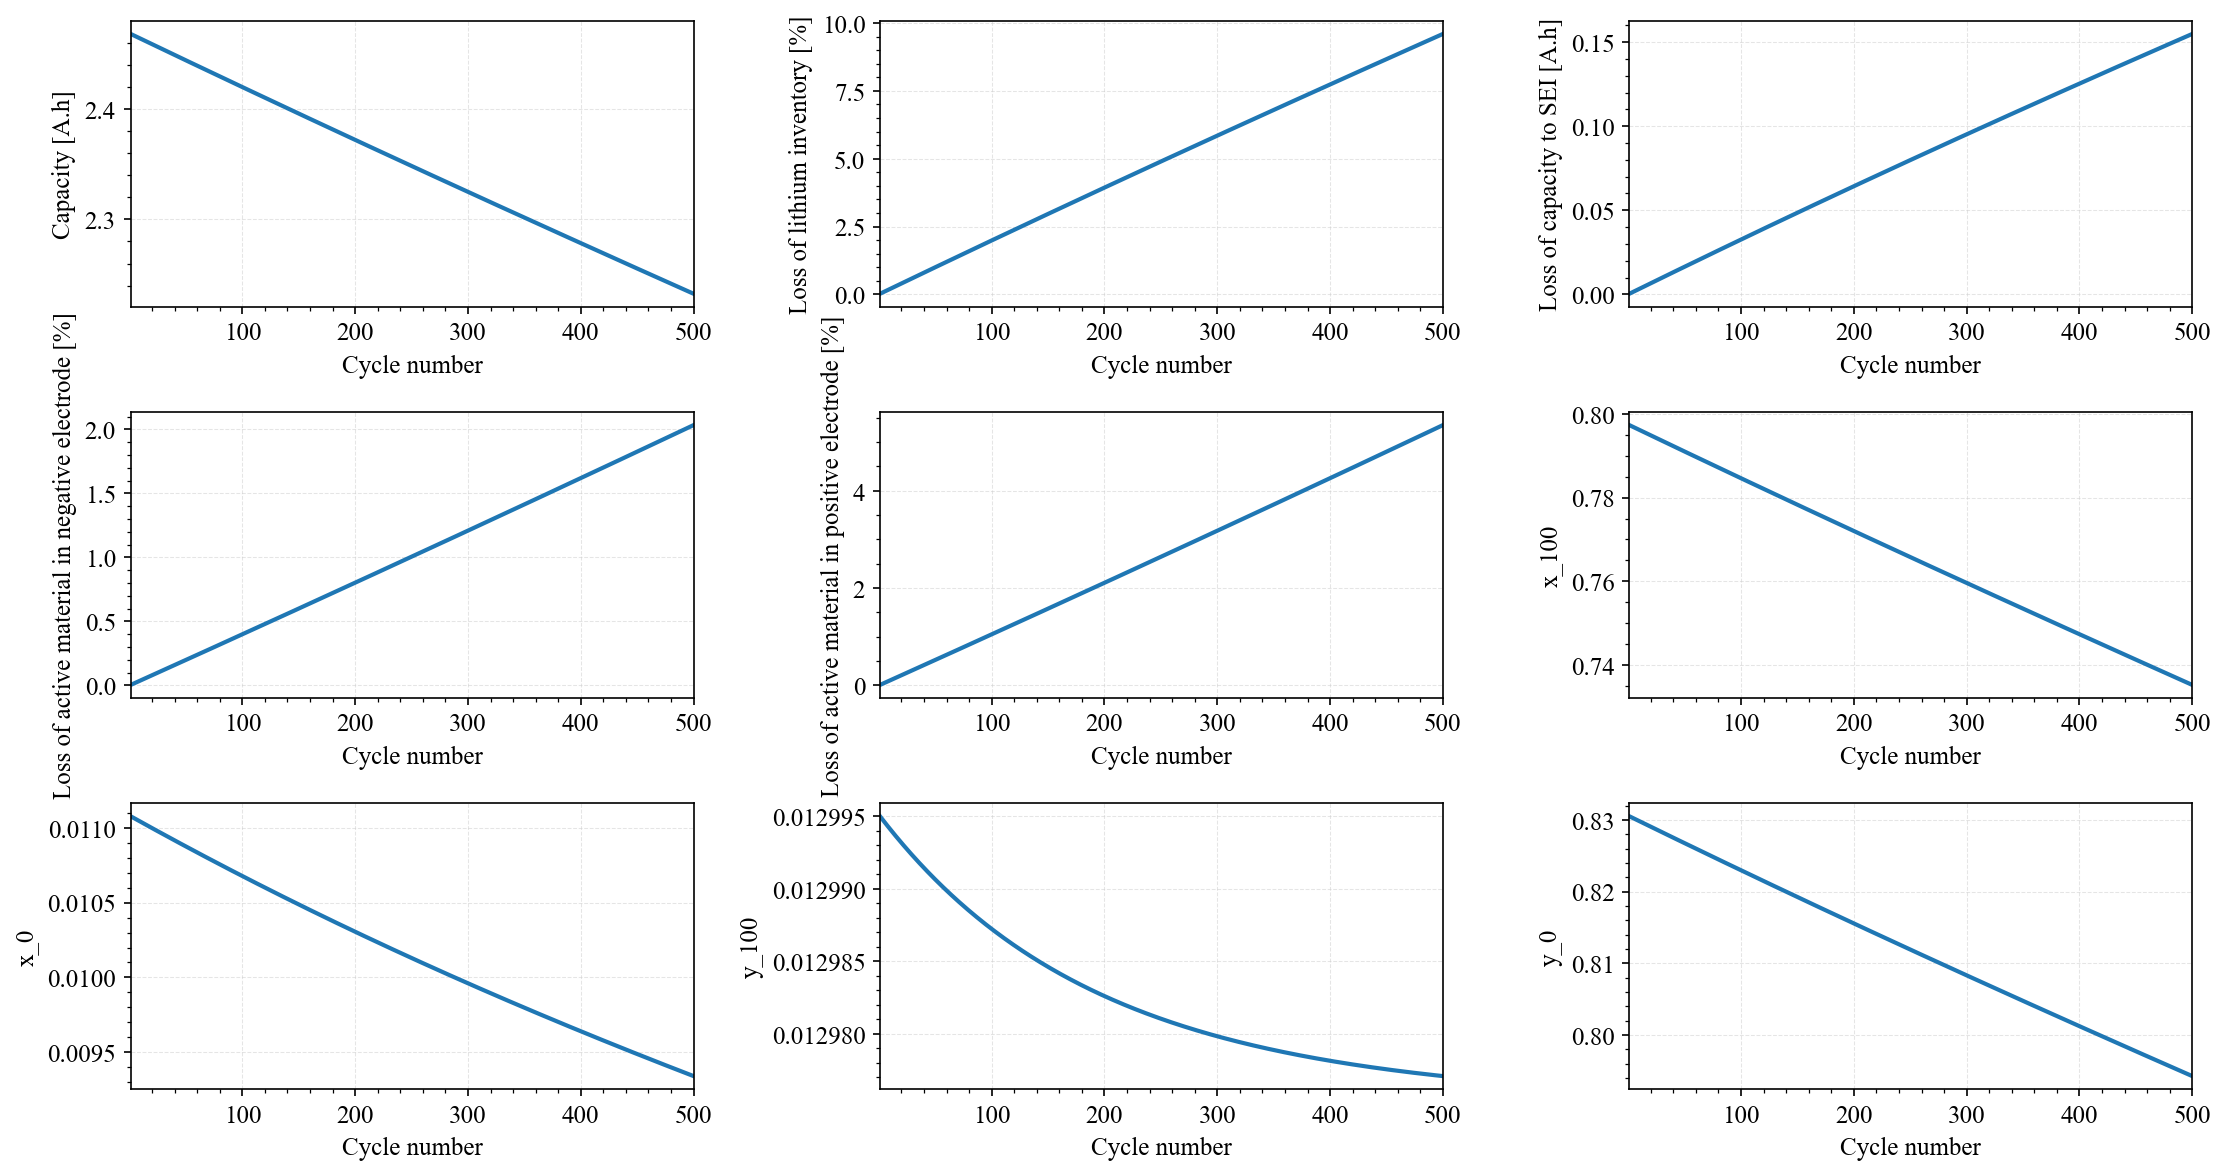

array([[<AxesSubplot: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [10]:
pybamm.plot_summary_variables(sol_long_Andrew_DriveOnly)

In [11]:
sim_long_Andrew_DriveOnly.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",

        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
        "Throughput capacity [A.h]"



        
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=1975.6525732902346, step=19.756525732902347)…

In [12]:
# ADdFEWF

In [13]:
parameter_values_peyman = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)

parameter_values_peyman.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [14]:
spm_peyman = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
        "calculate discharge energy":"true"
    }
)

In [15]:
# spm.print_parameter_info()
param_peyman=spm_peyman.param
# parameter_values_peyman.update(
#     {
# "Electrode width [m]":0.205,
# #     "Maximum concentration in negative electrode [mol.m-3]":30000,
# "Nominal cell capacity [A.h]":2.5,
# "Maximum concentration in positive electrode [mol.m-3]":37500
        
#     }
# )
parameter_values_peyman.search("maximum")

Maximum concentration in negative electrode [mol.m-3]	28746.0
Maximum concentration in positive electrode [mol.m-3]	35380.0


In [16]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm_peyman,parameter_values_peyman)
# Temp
# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
Temp


25

In [17]:
par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]


sno = 5


In [18]:





parameter_values_peyman.update(
    {
#         "Positive electrode LAM constant proportional term [s-1]":8.755e-8,   #2.5112e-07, #Using Sravan's new fit Dec27 2022
#         "Negative electrode LAM constant proportional term [s-1]":8.572e-7, #2.4741e-06,
#         "Positive electrode LAM constant exponential term":1.135, #1.1942,
#         "Negative electrode LAM constant exponential term":1.135,# 1.1942,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        
        "Upper voltage cut-off [V]":4.2,
        "SEI resistivity [Ohm.m]":30000.0
        
        
    },
    check_already_exists=False,
)

In [19]:
Created_Drive_peyman = pd.read_csv(r"F:\Stefanapolu application\CRC\Drive Cycle\Created_Drive.csv", comment="#", header=None).to_numpy()
# pybamm.set_logging_level("WARNING")
experiment_Driveonly_peyman = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Creeted_Drive_peyman (A) for 2 hours",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V until C/10",  # needs fixing : last step +this step =2.5 hrs
 
        )

    ]*500,
    drive_cycles={"Creeted_Drive_peyman": Created_Drive_peyman},
    termination="60% capacity",
#     cccv_handling="ode",
)

eps_n_data

0.6234262178666925

In [20]:



sim_long_peyman_DriveOnly = pybamm.Simulation(spm_peyman, experiment=experiment_Driveonly_peyman, parameter_values=parameter_values_peyman, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long_peyman_DriveOnly = sim_long_peyman_DriveOnly .solve(initial_soc=1, save_at_cycles=20  )

2023-02-16 13:04:43.997 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/500 (18.283 ms elapsed) --------------------
2023-02-16 13:04:43.997 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:04:47.501 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:04:47.846 - [NOTICE] callbacks.on_step_start(182): Cycle 1/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:04:49.116 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.069 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:04:49.117 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/500 (5.138 s elapsed) --------------------
2023-02-16 13:04:49.118 - [NOTICE] callbacks.on_step_start(182): Cycle 2/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:04:52.290 - [NOTICE] callbacks.on_step_start(182): Cycle 2/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:04:52.520 - [NOTICE]

2023-02-16 13:05:46.471 - [NOTICE] callbacks.on_step_start(182): Cycle 14/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:05:47.381 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.050 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:05:47.381 - [NOTICE] callbacks.on_cycle_start(174): Cycle 15/500 (1 minute, 3 seconds elapsed) --------------------
2023-02-16 13:05:47.381 - [NOTICE] callbacks.on_step_start(182): Cycle 15/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:05:50.594 - [NOTICE] callbacks.on_step_start(182): Cycle 15/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:05:50.836 - [NOTICE] callbacks.on_step_start(182): Cycle 15/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:05:51.757 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.049 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:05:51.758 - [NOTICE] callbacks.on_cycle_start(174): Cycle 16/500 (1 minute, 8 seconds elapsed) --------------------
20

2023-02-16 13:06:44.918 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.032 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:06:44.918 - [NOTICE] callbacks.on_cycle_start(174): Cycle 28/500 (2 minutes, 1 second elapsed) --------------------
2023-02-16 13:06:44.918 - [NOTICE] callbacks.on_step_start(182): Cycle 28/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:06:48.155 - [NOTICE] callbacks.on_step_start(182): Cycle 28/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:06:48.389 - [NOTICE] callbacks.on_step_start(182): Cycle 28/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:06:49.298 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.030 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:06:49.298 - [NOTICE] callbacks.on_cycle_start(174): Cycle 29/500 (2 minutes, 5 seconds elapsed) --------------------
2023-02-16 13:06:49.298 - [NOTICE] callbacks.on_step_start(182): Cycle 29/500, step 1/3: Run Creeted_Drive_peyman 

2023-02-16 13:07:43.286 - [NOTICE] callbacks.on_cycle_start(174): Cycle 41/500 (2 minutes, 59 seconds elapsed) --------------------
2023-02-16 13:07:43.286 - [NOTICE] callbacks.on_step_start(182): Cycle 41/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:07:46.523 - [NOTICE] callbacks.on_step_start(182): Cycle 41/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:07:46.752 - [NOTICE] callbacks.on_step_start(182): Cycle 41/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:07:47.671 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.011 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:07:47.671 - [NOTICE] callbacks.on_cycle_start(174): Cycle 42/500 (3 minutes, 4 seconds elapsed) --------------------
2023-02-16 13:07:47.671 - [NOTICE] callbacks.on_step_start(182): Cycle 42/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:07:50.930 - [NOTICE] callbacks.on_step_start(182): Cycle 42/500, step 2/3: Charge at C/4 until 4.2V
20

2023-02-16 13:08:41.082 - [NOTICE] callbacks.on_step_start(182): Cycle 54/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:08:44.415 - [NOTICE] callbacks.on_step_start(182): Cycle 54/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:08:44.641 - [NOTICE] callbacks.on_step_start(182): Cycle 54/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:08:45.569 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.991 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:08:45.569 - [NOTICE] callbacks.on_cycle_start(174): Cycle 55/500 (4 minutes, 2 seconds elapsed) --------------------
2023-02-16 13:08:45.569 - [NOTICE] callbacks.on_step_start(182): Cycle 55/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:08:48.899 - [NOTICE] callbacks.on_step_start(182): Cycle 55/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:08:49.126 - [NOTICE] callbacks.on_step_start(182): Cycle 55/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:08:50.0

2023-02-16 13:09:45.010 - [NOTICE] callbacks.on_step_start(182): Cycle 67/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:09:45.246 - [NOTICE] callbacks.on_step_start(182): Cycle 67/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:09:46.199 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.971 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:09:46.209 - [NOTICE] callbacks.on_cycle_start(174): Cycle 68/500 (5 minutes, 2 seconds elapsed) --------------------
2023-02-16 13:09:46.209 - [NOTICE] callbacks.on_step_start(182): Cycle 68/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:09:49.763 - [NOTICE] callbacks.on_step_start(182): Cycle 68/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:09:49.992 - [NOTICE] callbacks.on_step_start(182): Cycle 68/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:09:50.935 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.970 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:09:

2023-02-16 13:10:46.947 - [NOTICE] callbacks.on_step_start(182): Cycle 80/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:10:47.907 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.951 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:10:47.907 - [NOTICE] callbacks.on_cycle_start(174): Cycle 81/500 (6 minutes, 4 seconds elapsed) --------------------
2023-02-16 13:10:47.907 - [NOTICE] callbacks.on_step_start(182): Cycle 81/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:10:51.415 - [NOTICE] callbacks.on_step_start(182): Cycle 81/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:10:51.636 - [NOTICE] callbacks.on_step_start(182): Cycle 81/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:10:52.594 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.949 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:10:52.594 - [NOTICE] callbacks.on_cycle_start(174): Cycle 82/500 (6 minutes, 9 seconds elapsed) --------------------


2023-02-16 13:11:46.860 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.930 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:11:46.861 - [NOTICE] callbacks.on_cycle_start(174): Cycle 94/500 (7 minutes, 3 seconds elapsed) --------------------
2023-02-16 13:11:46.862 - [NOTICE] callbacks.on_step_start(182): Cycle 94/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:11:49.986 - [NOTICE] callbacks.on_step_start(182): Cycle 94/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:11:50.195 - [NOTICE] callbacks.on_step_start(182): Cycle 94/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:11:51.108 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.929 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:11:51.109 - [NOTICE] callbacks.on_cycle_start(174): Cycle 95/500 (7 minutes, 7 seconds elapsed) --------------------
2023-02-16 13:11:51.111 - [NOTICE] callbacks.on_step_start(182): Cycle 95/500, step 1/3: Run Creeted_Drive_peyman

2023-02-16 13:12:41.435 - [NOTICE] callbacks.on_cycle_start(174): Cycle 107/500 (7 minutes, 57 seconds elapsed) --------------------
2023-02-16 13:12:41.435 - [NOTICE] callbacks.on_step_start(182): Cycle 107/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:12:44.430 - [NOTICE] callbacks.on_step_start(182): Cycle 107/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:12:44.638 - [NOTICE] callbacks.on_step_start(182): Cycle 107/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:12:45.547 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.908 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:12:45.547 - [NOTICE] callbacks.on_cycle_start(174): Cycle 108/500 (8 minutes, 2 seconds elapsed) --------------------
2023-02-16 13:12:45.557 - [NOTICE] callbacks.on_step_start(182): Cycle 108/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:12:49.102 - [NOTICE] callbacks.on_step_start(182): Cycle 108/500, step 2/3: Charge at C/4 until 

2023-02-16 13:13:35.084 - [NOTICE] callbacks.on_step_start(182): Cycle 120/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:13:37.992 - [NOTICE] callbacks.on_step_start(182): Cycle 120/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:13:38.200 - [NOTICE] callbacks.on_step_start(182): Cycle 120/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:13:39.112 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.888 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:13:39.112 - [NOTICE] callbacks.on_cycle_start(174): Cycle 121/500 (8 minutes, 55 seconds elapsed) --------------------
2023-02-16 13:13:39.112 - [NOTICE] callbacks.on_step_start(182): Cycle 121/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:13:42.041 - [NOTICE] callbacks.on_step_start(182): Cycle 121/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:13:42.241 - [NOTICE] callbacks.on_step_start(182): Cycle 121/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13

2023-02-16 13:14:31.358 - [NOTICE] callbacks.on_step_start(182): Cycle 133/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:14:31.560 - [NOTICE] callbacks.on_step_start(182): Cycle 133/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:14:32.475 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.867 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:14:32.475 - [NOTICE] callbacks.on_cycle_start(174): Cycle 134/500 (9 minutes, 48 seconds elapsed) --------------------
2023-02-16 13:14:32.475 - [NOTICE] callbacks.on_step_start(182): Cycle 134/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:14:35.414 - [NOTICE] callbacks.on_step_start(182): Cycle 134/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:14:35.622 - [NOTICE] callbacks.on_step_start(182): Cycle 134/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:14:36.555 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.865 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16

2023-02-16 13:15:25.035 - [NOTICE] callbacks.on_step_start(182): Cycle 146/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:15:25.942 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.846 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:15:25.942 - [NOTICE] callbacks.on_cycle_start(174): Cycle 147/500 (10 minutes, 42 seconds elapsed) --------------------
2023-02-16 13:15:25.942 - [NOTICE] callbacks.on_step_start(182): Cycle 147/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:15:28.826 - [NOTICE] callbacks.on_step_start(182): Cycle 147/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:15:29.029 - [NOTICE] callbacks.on_step_start(182): Cycle 147/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:15:29.935 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.844 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:15:29.935 - [NOTICE] callbacks.on_cycle_start(174): Cycle 148/500 (10 minutes, 46 seconds elapsed) -----------

2023-02-16 13:16:18.372 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.825 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:16:18.372 - [NOTICE] callbacks.on_cycle_start(174): Cycle 160/500 (11 minutes, 34 seconds elapsed) --------------------
2023-02-16 13:16:18.382 - [NOTICE] callbacks.on_step_start(182): Cycle 160/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:16:21.260 - [NOTICE] callbacks.on_step_start(182): Cycle 160/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:16:21.462 - [NOTICE] callbacks.on_step_start(182): Cycle 160/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:16:22.381 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.823 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:16:22.382 - [NOTICE] callbacks.on_cycle_start(174): Cycle 161/500 (11 minutes, 38 seconds elapsed) --------------------
2023-02-16 13:16:22.383 - [NOTICE] callbacks.on_step_start(182): Cycle 161/500, step 1/3: Run Creeted_Dr

2023-02-16 13:17:11.325 - [NOTICE] callbacks.on_cycle_start(174): Cycle 173/500 (12 minutes, 27 seconds elapsed) --------------------
2023-02-16 13:17:11.325 - [NOTICE] callbacks.on_step_start(182): Cycle 173/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:17:14.271 - [NOTICE] callbacks.on_step_start(182): Cycle 173/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:17:14.475 - [NOTICE] callbacks.on_step_start(182): Cycle 173/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:17:15.407 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.802 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:17:15.408 - [NOTICE] callbacks.on_cycle_start(174): Cycle 174/500 (12 minutes, 31 seconds elapsed) --------------------
2023-02-16 13:17:15.409 - [NOTICE] callbacks.on_step_start(182): Cycle 174/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:17:18.279 - [NOTICE] callbacks.on_step_start(182): Cycle 174/500, step 2/3: Charge at C/4 unt

2023-02-16 13:18:04.109 - [NOTICE] callbacks.on_step_start(182): Cycle 186/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:18:06.991 - [NOTICE] callbacks.on_step_start(182): Cycle 186/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:18:07.185 - [NOTICE] callbacks.on_step_start(182): Cycle 186/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:18:08.102 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.781 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:18:08.102 - [NOTICE] callbacks.on_cycle_start(174): Cycle 187/500 (13 minutes, 24 seconds elapsed) --------------------
2023-02-16 13:18:08.102 - [NOTICE] callbacks.on_step_start(182): Cycle 187/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:18:10.988 - [NOTICE] callbacks.on_step_start(182): Cycle 187/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:18:11.188 - [NOTICE] callbacks.on_step_start(182): Cycle 187/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 1

2023-02-16 13:18:59.470 - [NOTICE] callbacks.on_step_start(182): Cycle 199/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:18:59.677 - [NOTICE] callbacks.on_step_start(182): Cycle 199/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:19:00.585 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.760 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:19:00.585 - [NOTICE] callbacks.on_cycle_start(174): Cycle 200/500 (14 minutes, 17 seconds elapsed) --------------------
2023-02-16 13:19:00.585 - [NOTICE] callbacks.on_step_start(182): Cycle 200/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:19:04.185 - [NOTICE] callbacks.on_step_start(182): Cycle 200/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:19:04.403 - [NOTICE] callbacks.on_step_start(182): Cycle 200/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:19:05.326 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.759 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-1

2023-02-16 13:19:52.702 - [NOTICE] callbacks.on_step_start(182): Cycle 212/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:19:53.618 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.739 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:19:53.618 - [NOTICE] callbacks.on_cycle_start(174): Cycle 213/500 (15 minutes, 10 seconds elapsed) --------------------
2023-02-16 13:19:53.618 - [NOTICE] callbacks.on_step_start(182): Cycle 213/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:19:56.504 - [NOTICE] callbacks.on_step_start(182): Cycle 213/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:19:56.695 - [NOTICE] callbacks.on_step_start(182): Cycle 213/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:19:57.624 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.738 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:19:57.624 - [NOTICE] callbacks.on_cycle_start(174): Cycle 214/500 (15 minutes, 14 seconds elapsed) -----------

2023-02-16 13:20:46.378 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.718 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:20:46.378 - [NOTICE] callbacks.on_cycle_start(174): Cycle 226/500 (16 minutes, 2 seconds elapsed) --------------------
2023-02-16 13:20:46.378 - [NOTICE] callbacks.on_step_start(182): Cycle 226/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:20:49.339 - [NOTICE] callbacks.on_step_start(182): Cycle 226/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:20:49.546 - [NOTICE] callbacks.on_step_start(182): Cycle 226/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:20:50.455 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.716 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:20:50.455 - [NOTICE] callbacks.on_cycle_start(174): Cycle 227/500 (16 minutes, 6 seconds elapsed) --------------------
2023-02-16 13:20:50.455 - [NOTICE] callbacks.on_step_start(182): Cycle 227/500, step 1/3: Run Creeted_Driv

2023-02-16 13:21:38.657 - [NOTICE] callbacks.on_cycle_start(174): Cycle 239/500 (16 minutes, 55 seconds elapsed) --------------------
2023-02-16 13:21:38.657 - [NOTICE] callbacks.on_step_start(182): Cycle 239/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:21:42.232 - [NOTICE] callbacks.on_step_start(182): Cycle 239/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:21:42.439 - [NOTICE] callbacks.on_step_start(182): Cycle 239/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:21:43.357 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.695 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:21:43.367 - [NOTICE] callbacks.on_cycle_start(174): Cycle 240/500 (16 minutes, 59 seconds elapsed) --------------------
2023-02-16 13:21:43.367 - [NOTICE] callbacks.on_step_start(182): Cycle 240/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:21:46.289 - [NOTICE] callbacks.on_step_start(182): Cycle 240/500, step 2/3: Charge at C/4 unt

2023-02-16 13:22:31.637 - [NOTICE] callbacks.on_step_start(182): Cycle 252/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:22:34.739 - [NOTICE] callbacks.on_step_start(182): Cycle 252/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:22:34.949 - [NOTICE] callbacks.on_step_start(182): Cycle 252/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:22:35.922 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.674 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:22:35.932 - [NOTICE] callbacks.on_cycle_start(174): Cycle 253/500 (17 minutes, 52 seconds elapsed) --------------------
2023-02-16 13:22:35.932 - [NOTICE] callbacks.on_step_start(182): Cycle 253/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:22:38.841 - [NOTICE] callbacks.on_step_start(182): Cycle 253/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:22:39.041 - [NOTICE] callbacks.on_step_start(182): Cycle 253/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 1

2023-02-16 13:23:27.798 - [NOTICE] callbacks.on_step_start(182): Cycle 265/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:23:27.998 - [NOTICE] callbacks.on_step_start(182): Cycle 265/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:23:28.902 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.653 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:23:28.902 - [NOTICE] callbacks.on_cycle_start(174): Cycle 266/500 (18 minutes, 45 seconds elapsed) --------------------
2023-02-16 13:23:28.902 - [NOTICE] callbacks.on_step_start(182): Cycle 266/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:23:31.842 - [NOTICE] callbacks.on_step_start(182): Cycle 266/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:23:32.038 - [NOTICE] callbacks.on_step_start(182): Cycle 266/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:23:32.948 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.651 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-1

2023-02-16 13:24:21.451 - [NOTICE] callbacks.on_step_start(182): Cycle 278/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:24:22.358 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.632 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:24:22.358 - [NOTICE] callbacks.on_cycle_start(174): Cycle 279/500 (19 minutes, 38 seconds elapsed) --------------------
2023-02-16 13:24:22.368 - [NOTICE] callbacks.on_step_start(182): Cycle 279/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:24:25.304 - [NOTICE] callbacks.on_step_start(182): Cycle 279/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:24:25.504 - [NOTICE] callbacks.on_step_start(182): Cycle 279/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:24:26.446 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.630 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:24:26.446 - [NOTICE] callbacks.on_cycle_start(174): Cycle 280/500 (19 minutes, 42 seconds elapsed) -----------

2023-02-16 13:25:15.080 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.610 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:25:15.081 - [NOTICE] callbacks.on_cycle_start(174): Cycle 292/500 (20 minutes, 31 seconds elapsed) --------------------
2023-02-16 13:25:15.082 - [NOTICE] callbacks.on_step_start(182): Cycle 292/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:25:17.982 - [NOTICE] callbacks.on_step_start(182): Cycle 292/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:25:18.180 - [NOTICE] callbacks.on_step_start(182): Cycle 292/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:25:19.102 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.609 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:25:19.112 - [NOTICE] callbacks.on_cycle_start(174): Cycle 293/500 (20 minutes, 35 seconds elapsed) --------------------
2023-02-16 13:25:19.112 - [NOTICE] callbacks.on_step_start(182): Cycle 293/500, step 1/3: Run Creeted_Dr

2023-02-16 13:26:08.273 - [NOTICE] callbacks.on_cycle_start(174): Cycle 305/500 (21 minutes, 24 seconds elapsed) --------------------
2023-02-16 13:26:08.273 - [NOTICE] callbacks.on_step_start(182): Cycle 305/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:26:11.181 - [NOTICE] callbacks.on_step_start(182): Cycle 305/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:26:11.377 - [NOTICE] callbacks.on_step_start(182): Cycle 305/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:26:12.291 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.587 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:26:12.291 - [NOTICE] callbacks.on_cycle_start(174): Cycle 306/500 (21 minutes, 28 seconds elapsed) --------------------
2023-02-16 13:26:12.291 - [NOTICE] callbacks.on_step_start(182): Cycle 306/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:26:15.206 - [NOTICE] callbacks.on_step_start(182): Cycle 306/500, step 2/3: Charge at C/4 unt

2023-02-16 13:27:00.707 - [NOTICE] callbacks.on_step_start(182): Cycle 318/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:27:03.658 - [NOTICE] callbacks.on_step_start(182): Cycle 318/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:27:03.860 - [NOTICE] callbacks.on_step_start(182): Cycle 318/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:27:04.798 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.566 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:27:04.798 - [NOTICE] callbacks.on_cycle_start(174): Cycle 319/500 (22 minutes, 21 seconds elapsed) --------------------
2023-02-16 13:27:04.808 - [NOTICE] callbacks.on_step_start(182): Cycle 319/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:27:08.438 - [NOTICE] callbacks.on_step_start(182): Cycle 319/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:27:08.638 - [NOTICE] callbacks.on_step_start(182): Cycle 319/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 1

2023-02-16 13:27:57.039 - [NOTICE] callbacks.on_step_start(182): Cycle 331/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:27:57.243 - [NOTICE] callbacks.on_step_start(182): Cycle 331/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:27:58.152 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.544 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:27:58.162 - [NOTICE] callbacks.on_cycle_start(174): Cycle 332/500 (23 minutes, 14 seconds elapsed) --------------------
2023-02-16 13:27:58.162 - [NOTICE] callbacks.on_step_start(182): Cycle 332/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:28:01.067 - [NOTICE] callbacks.on_step_start(182): Cycle 332/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:28:01.270 - [NOTICE] callbacks.on_step_start(182): Cycle 332/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:28:02.188 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.543 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-1

2023-02-16 13:28:50.444 - [NOTICE] callbacks.on_step_start(182): Cycle 344/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:28:51.355 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.523 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:28:51.355 - [NOTICE] callbacks.on_cycle_start(174): Cycle 345/500 (24 minutes, 7 seconds elapsed) --------------------
2023-02-16 13:28:51.355 - [NOTICE] callbacks.on_step_start(182): Cycle 345/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:28:54.243 - [NOTICE] callbacks.on_step_start(182): Cycle 345/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:28:54.453 - [NOTICE] callbacks.on_step_start(182): Cycle 345/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:28:55.376 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.521 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:28:55.376 - [NOTICE] callbacks.on_cycle_start(174): Cycle 346/500 (24 minutes, 11 seconds elapsed) ------------

2023-02-16 13:29:43.864 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.502 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:29:43.864 - [NOTICE] callbacks.on_cycle_start(174): Cycle 358/500 (25 minutes, 0 seconds elapsed) --------------------
2023-02-16 13:29:43.874 - [NOTICE] callbacks.on_step_start(182): Cycle 358/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:29:46.793 - [NOTICE] callbacks.on_step_start(182): Cycle 358/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:29:46.990 - [NOTICE] callbacks.on_step_start(182): Cycle 358/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:29:47.909 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.500 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:29:47.909 - [NOTICE] callbacks.on_cycle_start(174): Cycle 359/500 (25 minutes, 4 seconds elapsed) --------------------
2023-02-16 13:29:47.909 - [NOTICE] callbacks.on_step_start(182): Cycle 359/500, step 1/3: Run Creeted_Driv

2023-02-16 13:30:37.056 - [NOTICE] callbacks.on_cycle_start(174): Cycle 371/500 (25 minutes, 53 seconds elapsed) --------------------
2023-02-16 13:30:37.056 - [NOTICE] callbacks.on_step_start(182): Cycle 371/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:30:39.969 - [NOTICE] callbacks.on_step_start(182): Cycle 371/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:30:40.157 - [NOTICE] callbacks.on_step_start(182): Cycle 371/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:30:41.087 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.478 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:30:41.097 - [NOTICE] callbacks.on_cycle_start(174): Cycle 372/500 (25 minutes, 57 seconds elapsed) --------------------
2023-02-16 13:30:41.097 - [NOTICE] callbacks.on_step_start(182): Cycle 372/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:30:44.019 - [NOTICE] callbacks.on_step_start(182): Cycle 372/500, step 2/3: Charge at C/4 unt

2023-02-16 13:31:30.357 - [NOTICE] callbacks.on_step_start(182): Cycle 384/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:31:33.291 - [NOTICE] callbacks.on_step_start(182): Cycle 384/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:31:33.493 - [NOTICE] callbacks.on_step_start(182): Cycle 384/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:31:34.396 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.457 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:31:34.396 - [NOTICE] callbacks.on_cycle_start(174): Cycle 385/500 (26 minutes, 50 seconds elapsed) --------------------
2023-02-16 13:31:34.396 - [NOTICE] callbacks.on_step_start(182): Cycle 385/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:31:37.286 - [NOTICE] callbacks.on_step_start(182): Cycle 385/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:31:37.481 - [NOTICE] callbacks.on_step_start(182): Cycle 385/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 1

2023-02-16 13:32:26.086 - [NOTICE] callbacks.on_step_start(182): Cycle 397/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:32:26.279 - [NOTICE] callbacks.on_step_start(182): Cycle 397/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:32:27.212 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.435 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:32:27.212 - [NOTICE] callbacks.on_cycle_start(174): Cycle 398/500 (27 minutes, 43 seconds elapsed) --------------------
2023-02-16 13:32:27.212 - [NOTICE] callbacks.on_step_start(182): Cycle 398/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:32:30.100 - [NOTICE] callbacks.on_step_start(182): Cycle 398/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:32:30.297 - [NOTICE] callbacks.on_step_start(182): Cycle 398/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:32:31.239 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.434 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-1

2023-02-16 13:33:20.751 - [NOTICE] callbacks.on_step_start(182): Cycle 410/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:33:21.781 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.414 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:33:21.782 - [NOTICE] callbacks.on_cycle_start(174): Cycle 411/500 (28 minutes, 38 seconds elapsed) --------------------
2023-02-16 13:33:21.783 - [NOTICE] callbacks.on_step_start(182): Cycle 411/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:33:24.991 - [NOTICE] callbacks.on_step_start(182): Cycle 411/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:33:25.198 - [NOTICE] callbacks.on_step_start(182): Cycle 411/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:33:26.186 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.412 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:33:26.187 - [NOTICE] callbacks.on_cycle_start(174): Cycle 412/500 (28 minutes, 42 seconds elapsed) -----------

2023-02-16 13:34:17.920 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.392 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:34:17.921 - [NOTICE] callbacks.on_cycle_start(174): Cycle 424/500 (29 minutes, 34 seconds elapsed) --------------------
2023-02-16 13:34:17.922 - [NOTICE] callbacks.on_step_start(182): Cycle 424/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:34:20.988 - [NOTICE] callbacks.on_step_start(182): Cycle 424/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:34:21.191 - [NOTICE] callbacks.on_step_start(182): Cycle 424/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:34:22.117 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.390 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:34:22.117 - [NOTICE] callbacks.on_cycle_start(174): Cycle 425/500 (29 minutes, 38 seconds elapsed) --------------------
2023-02-16 13:34:22.117 - [NOTICE] callbacks.on_step_start(182): Cycle 425/500, step 1/3: Run Creeted_Dr

2023-02-16 13:35:12.445 - [NOTICE] callbacks.on_cycle_start(174): Cycle 437/500 (30 minutes, 28 seconds elapsed) --------------------
2023-02-16 13:35:12.455 - [NOTICE] callbacks.on_step_start(182): Cycle 437/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:35:15.466 - [NOTICE] callbacks.on_step_start(182): Cycle 437/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:35:15.670 - [NOTICE] callbacks.on_step_start(182): Cycle 437/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:35:16.601 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.368 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:35:16.611 - [NOTICE] callbacks.on_cycle_start(174): Cycle 438/500 (30 minutes, 33 seconds elapsed) --------------------
2023-02-16 13:35:16.611 - [NOTICE] callbacks.on_step_start(182): Cycle 438/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:35:19.540 - [NOTICE] callbacks.on_step_start(182): Cycle 438/500, step 2/3: Charge at C/4 unt

2023-02-16 13:36:05.897 - [NOTICE] callbacks.on_step_start(182): Cycle 450/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:36:08.815 - [NOTICE] callbacks.on_step_start(182): Cycle 450/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:36:09.022 - [NOTICE] callbacks.on_step_start(182): Cycle 450/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:36:10.742 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.347 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:36:10.742 - [NOTICE] callbacks.on_cycle_start(174): Cycle 451/500 (31 minutes, 27 seconds elapsed) --------------------
2023-02-16 13:36:10.742 - [NOTICE] callbacks.on_step_start(182): Cycle 451/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:36:13.762 - [NOTICE] callbacks.on_step_start(182): Cycle 451/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:36:13.974 - [NOTICE] callbacks.on_step_start(182): Cycle 451/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 1

2023-02-16 13:37:02.708 - [NOTICE] callbacks.on_step_start(182): Cycle 463/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:37:02.925 - [NOTICE] callbacks.on_step_start(182): Cycle 463/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:37:03.866 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.325 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:37:03.866 - [NOTICE] callbacks.on_cycle_start(174): Cycle 464/500 (32 minutes, 20 seconds elapsed) --------------------
2023-02-16 13:37:03.866 - [NOTICE] callbacks.on_step_start(182): Cycle 464/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:37:06.782 - [NOTICE] callbacks.on_step_start(182): Cycle 464/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:37:06.990 - [NOTICE] callbacks.on_step_start(182): Cycle 464/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:37:07.914 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.323 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-1

2023-02-16 13:37:56.732 - [NOTICE] callbacks.on_step_start(182): Cycle 476/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:37:57.669 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.303 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:37:57.669 - [NOTICE] callbacks.on_cycle_start(174): Cycle 477/500 (33 minutes, 14 seconds elapsed) --------------------
2023-02-16 13:37:57.669 - [NOTICE] callbacks.on_step_start(182): Cycle 477/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:38:00.620 - [NOTICE] callbacks.on_step_start(182): Cycle 477/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:38:00.832 - [NOTICE] callbacks.on_step_start(182): Cycle 477/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:38:01.762 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.301 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:38:01.762 - [NOTICE] callbacks.on_cycle_start(174): Cycle 478/500 (33 minutes, 18 seconds elapsed) -----------

2023-02-16 13:38:51.036 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.281 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:38:51.036 - [NOTICE] callbacks.on_cycle_start(174): Cycle 490/500 (34 minutes, 7 seconds elapsed) --------------------
2023-02-16 13:38:51.036 - [NOTICE] callbacks.on_step_start(182): Cycle 490/500, step 1/3: Run Creeted_Drive_peyman (A) for 2 hours
2023-02-16 13:38:53.994 - [NOTICE] callbacks.on_step_start(182): Cycle 490/500, step 2/3: Charge at C/4 until 4.2V
2023-02-16 13:38:54.196 - [NOTICE] callbacks.on_step_start(182): Cycle 490/500, step 3/3: Hold at 4.2V until C/10
2023-02-16 13:38:55.143 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.279 Ah (originally 5.069 Ah, will stop at 3.041 Ah)
2023-02-16 13:38:55.143 - [NOTICE] callbacks.on_cycle_start(174): Cycle 491/500 (34 minutes, 11 seconds elapsed) --------------------
2023-02-16 13:38:55.143 - [NOTICE] callbacks.on_step_start(182): Cycle 491/500, step 1/3: Run Creeted_Dri

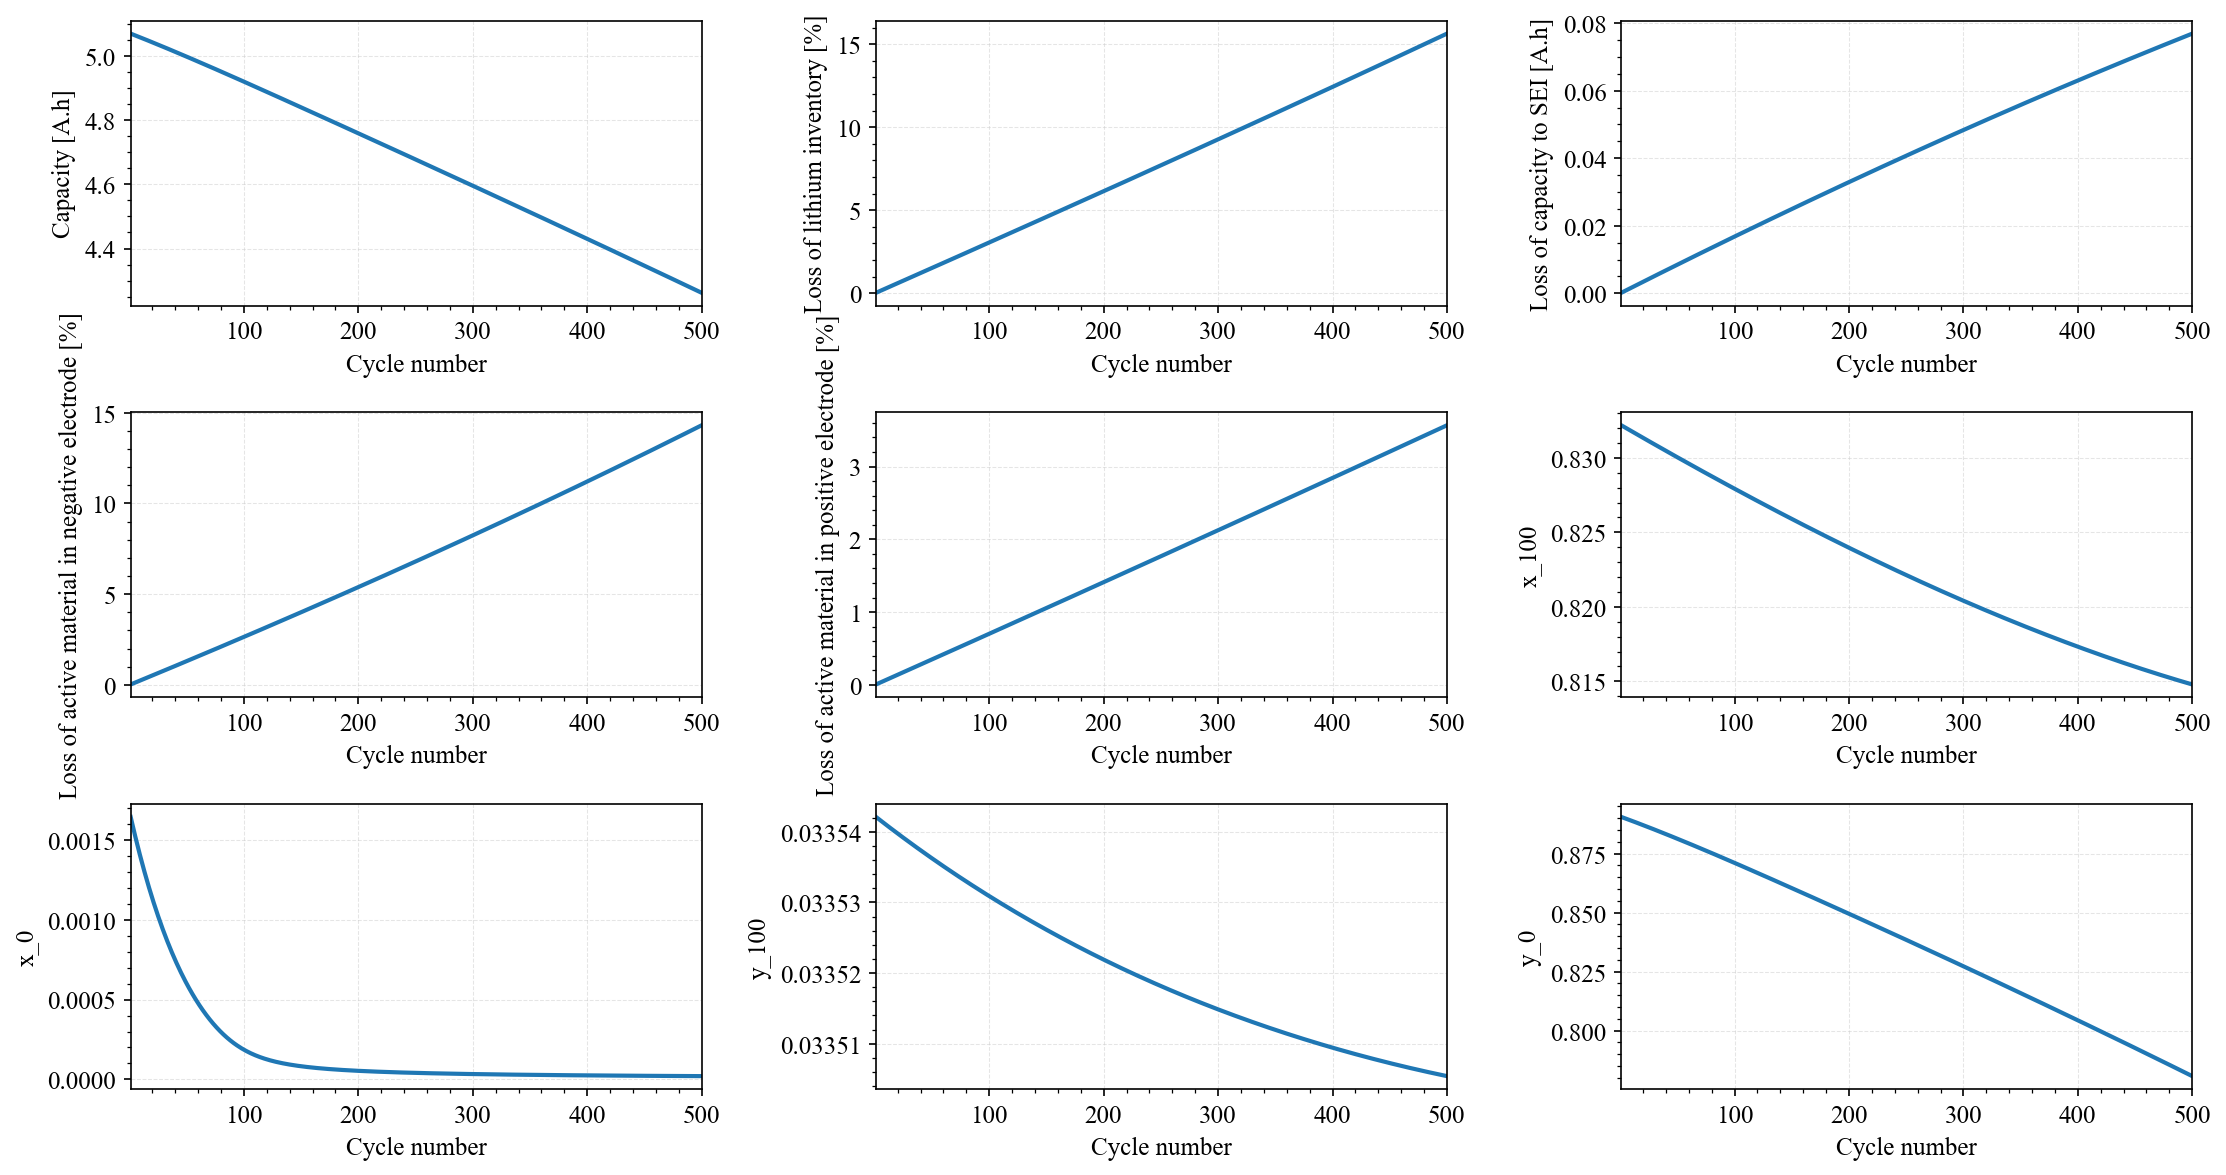

array([[<AxesSubplot: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of capacity to SEI [A.h]'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='x_100'>],
       [<AxesSubplot: xlabel='Cycle number', ylabel='x_0'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_100'>,
        <AxesSubplot: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [21]:
pybamm.plot_summary_variables(sol_long_peyman_DriveOnly)

In [22]:
sim_long_peyman_DriveOnly.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#,
        "Total lithium in particles [mol]",

        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
        "Throughput capacity [A.h]"



        
    ]
)

interactive(children=(FloatSlider(value=0.0, description='t', max=1974.514754788437, step=19.74514754788437), …

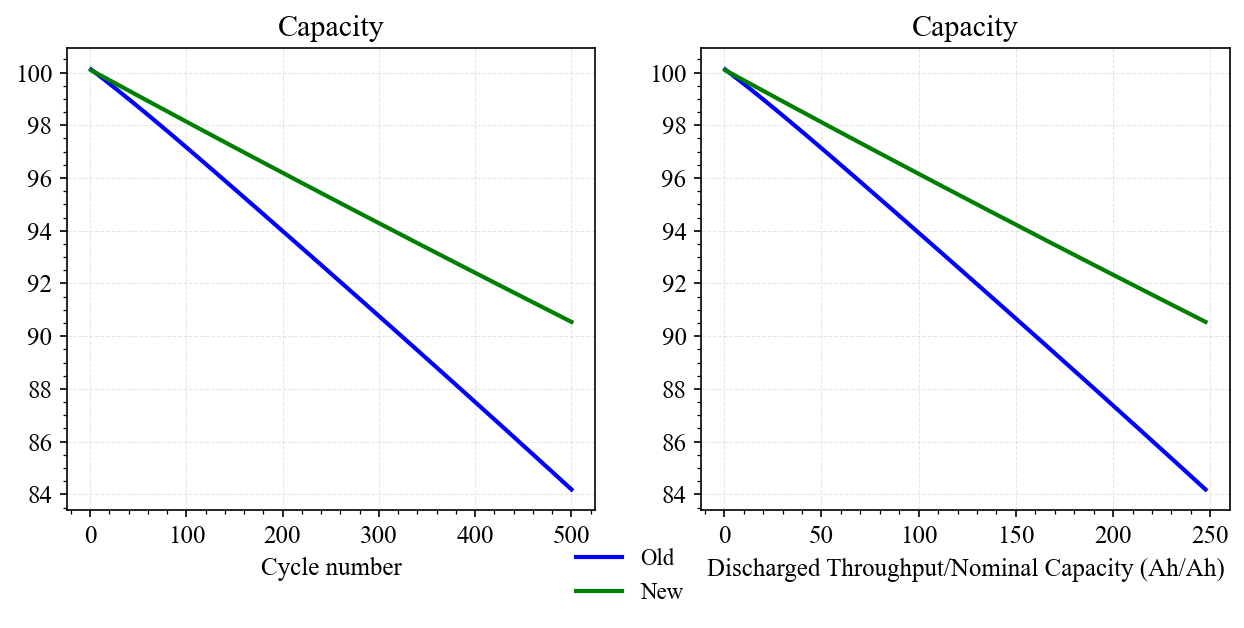

In [65]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[1]
ax.plot(sol_long_peyman_DriveOnly.summary_variables["Throughput capacity [A.h]"]/10,sol_long_peyman_DriveOnly.summary_variables["Capacity [A.h]"]/5.063*100,"b")
ax.plot(sol_long_Andrew_DriveOnly.summary_variables["Throughput capacity [A.h]"]/5,sol_long_Andrew_DriveOnly.summary_variables["Capacity [A.h]"]/2.4658*100,"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Discharged Throughput/Nominal Capacity (Ah/Ah)")

ax = axes.flat[0]
ax.plot(sol_long_peyman_DriveOnly.summary_variables["Cycle number"],sol_long_peyman_DriveOnly.summary_variables["Capacity [A.h]"]/5.063*100,"b")
ax.plot(sol_long_Andrew_DriveOnly.summary_variables["Cycle number"],sol_long_Andrew_DriveOnly.summary_variables["Capacity [A.h]"]/2.4658*100,"g")
ax.set_title("Capacity")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Cycle number")



fig.legend(["Old"] + ["New"], 
       loc="lower center",bbox_to_anchor=[0.5,-0.08], ncol=1, fontsize=11)

(3.4, 4.4)

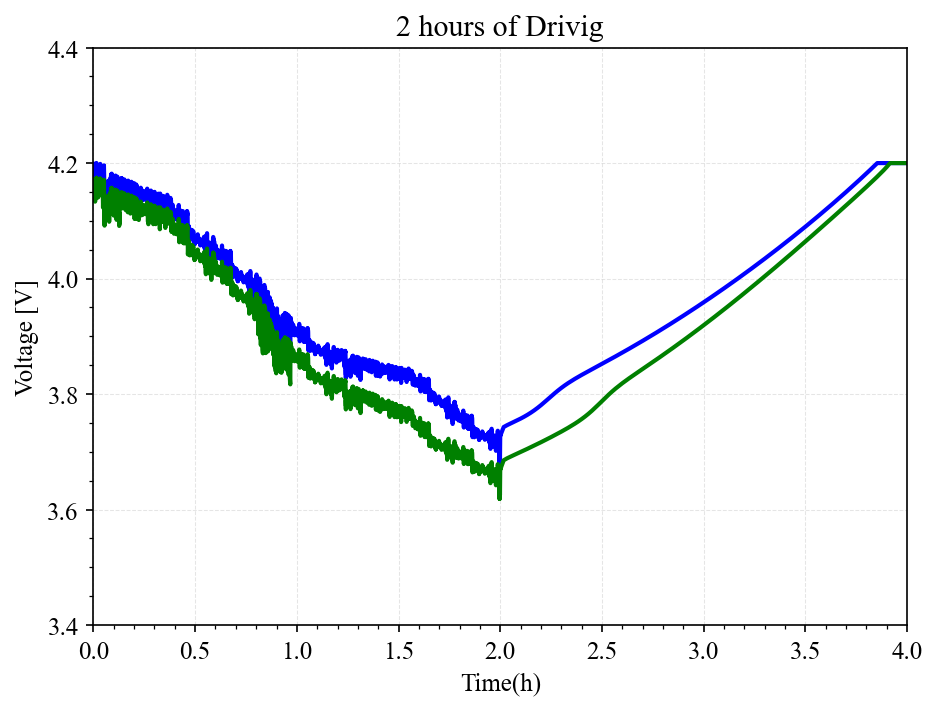

In [63]:
t_And_dr = sol_long_Andrew_DriveOnly['Time [h]'].entries
Vt_And_dr = sol_long_Andrew_DriveOnly["Terminal voltage [V]"].entries
t_Pey_dr = sol_long_peyman_DriveOnly['Time [h]'].entries
Vt_Pey_dr = sol_long_peyman_DriveOnly["Terminal voltage [V]"].entries

fig, axes = plt.subplots(1,1,figsize=(7,5))
ax = axes
ax.plot(t_Pey_dr,Vt_Pey_dr,'b')
ax.plot(t_And_dr,Vt_And_dr,'g')


# ax.legend(["Peyman"] + ["Andrew"], 
#        loc="lower center",bbox_to_anchor=[0.5,-0.20], ncol=1, fontsize=11)
ax.set_ylabel("Voltage [V]")
ax.set_xlabel("Time(h)")
ax.set_title("2 hours of Drivig")
ax.set_xlim(0,4)
ax.set_ylim(3.4,4.4)
